# Statistical analysis of pain studies

In [1]:
import os
import pandas as pd
import plotly.express as px

from src.pain_analysis import (preprocess_data, 
                               aggregate_features, 
                               select_features_with_lasso, 
                               plot_lasso_feature_importance, 
                               perform_dimensionality_reduction, 
                               plot_umap_feature_importance_with_xgboost)

/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [2]:
FIGURES_DIR = './figures/'
DATA_DIR = './csv/'
DATA_FILE = 'Pain_hindlimb_mouse_features_no_during_td_2025-06-05_16-48-56.csv'
# DATA_FILE = 'Pain_hindlimb_mouse_features_2025-05-23_15-06-55.csv'
# DATA_FILE = 'SCI_pre_acute_hindlimb_mouse_features_2025-06-06_15-11-59.csv'
DATASET_KEY = 'DLC'
# DATASET_KEY = '_Corridor_'

## Load the data
full_data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE))

## Drop unnecessary columns and merge
full_data['Dataset'] = full_data['Dataset'].str.replace(DATASET_KEY, '_') + full_data['Mouse'].str.split('_').str[1]
to_drop = ["Number of runs (#)", "Number of steps (#)"]
full_data.drop(columns=to_drop, inplace=True)

features_to_drop = [col for col in full_data.columns if ' at ' in col] # Drop features with ' at ' in their name to avoid outliers (~1500 features)
full_data.drop(columns=features_to_drop, inplace=True)

print(f'[DEBUG] Datasets: {full_data["Dataset"].unique()}')
print(f'[DEBUG] Feature count: {len(full_data.columns) - 2}')
print(f'[DEBUG] Mice count: {len(full_data)/2}')

## Preprocess data
preprocessed_data, dataset_label_map, mouse_label_map, label_cols = preprocess_data(full_data)

## Aggregate features
X_agg, y_mouse, y_dataset = aggregate_features(preprocessed_data, label_cols, method="median")#method="mean") # Nothing changes bc we have only one mouse per dataset

[DEBUG] Datasets: ['A_post_left' 'A_post_right' 'A_pre_left' 'A_pre_right' 'B_post_right'
 'B_post_left' 'B_pre_right' 'B_pre_left' 'C_post_right' 'C_post_left'
 'C_pre_left' 'C_pre_right' 'D_post_left' 'D_post_right' 'D_pre_right'
 'D_pre_left' 'E_post_right' 'E_post_left' 'E_pre_right' 'E_pre_left']
[DEBUG] Feature count: 1096
[DEBUG] Mice count: 100.0
[DEBUG] Dataset Label Map: {0: 'A_post_left', 1: 'A_post_right', 2: 'A_pre_left', 3: 'A_pre_right', 5: 'B_post_right', 4: 'B_post_left', 7: 'B_pre_right', 6: 'B_pre_left', 9: 'C_post_right', 8: 'C_post_left', 10: 'C_pre_left', 11: 'C_pre_right', 12: 'D_post_left', 13: 'D_post_right', 15: 'D_pre_right', 14: 'D_pre_left', 17: 'E_post_right', 16: 'E_post_left', 19: 'E_pre_right', 18: 'E_pre_left'}
[DEBUG] Mouse Label Map: {20: 'mouse1_left', 21: 'mouse1_right', 43: 'mouse2_right', 42: 'mouse2_left', 65: 'mouse3_right', 64: 'mouse3_left', 86: 'mouse4_left', 87: 'mouse4_right', 91: 'mouse5_right', 90: 'mouse5_left', 93: 'mouse6_right', 92: 

## Top features according to LASSO

/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e+01, tolerance: 6.425e-01
  model = cd_fast.enet_coordinate_descent(


[DEBUG] Selected 196 features out of 1096


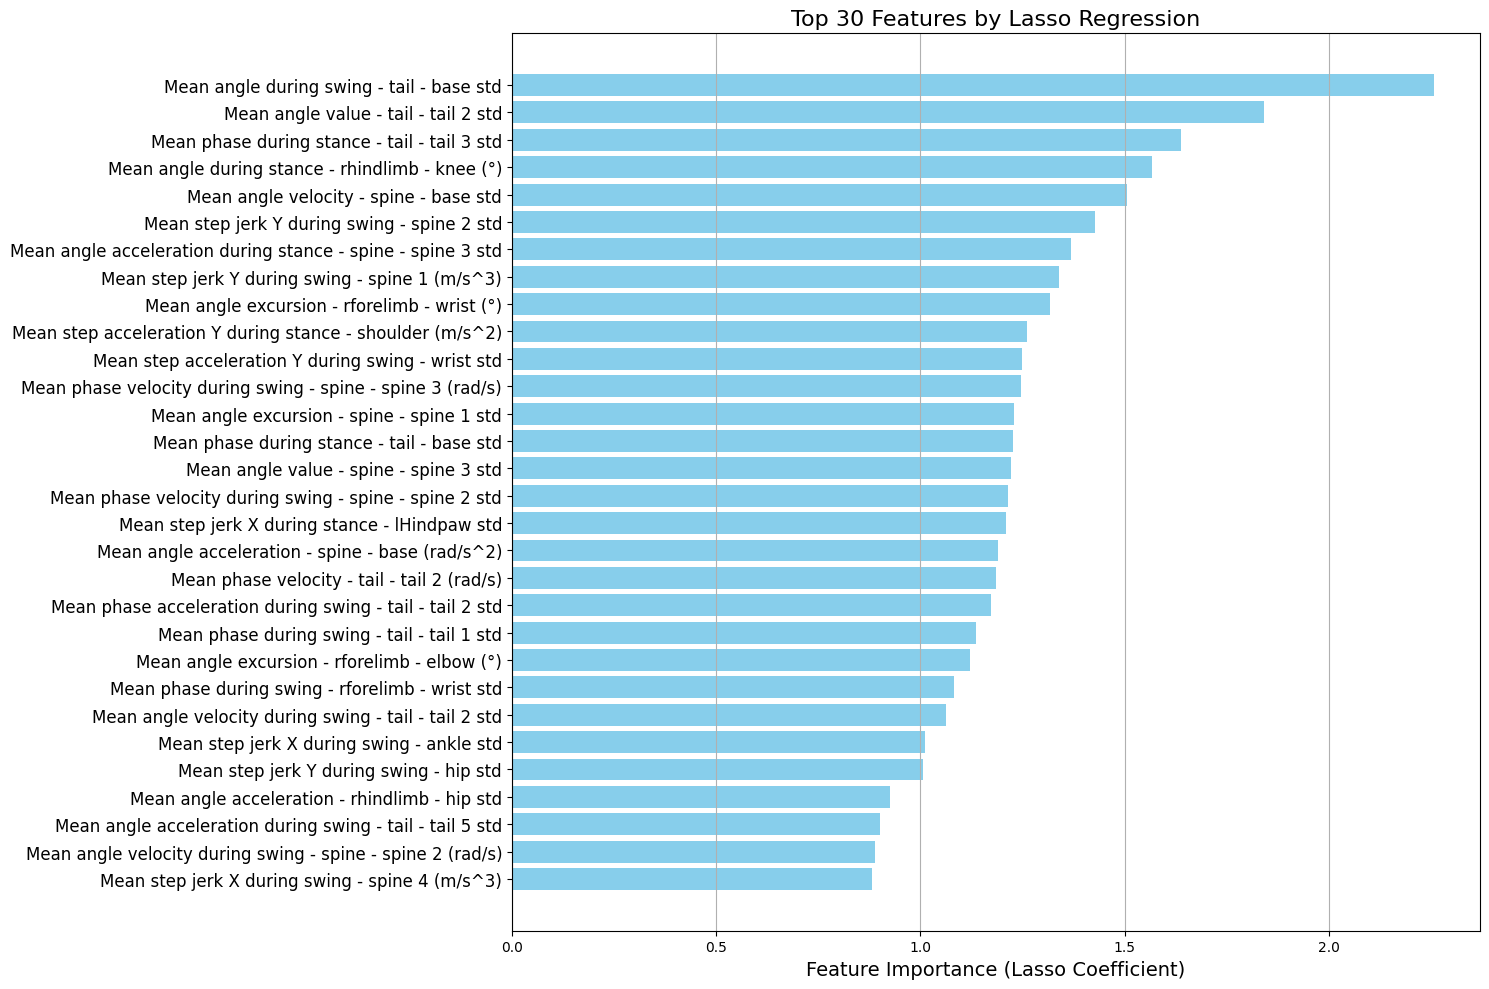

In [3]:
## Feature selection with LASSO
X_agg_lasso, selected_features, lasso_weights = select_features_with_lasso(
    X_agg,
    y_dataset,
    feature_names=X_agg.columns,
    # use_cv=True,  # Use LassoCV to find optimal alpha
    alpha=0.01,  # or use_cv=True
    top_k=None   # or top_k=50 for a fixed limit
)

plot_lasso_feature_importance(lasso_weights, top_k=30)

## PCA

/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/src/pain_analysis.py:237: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space for external legend


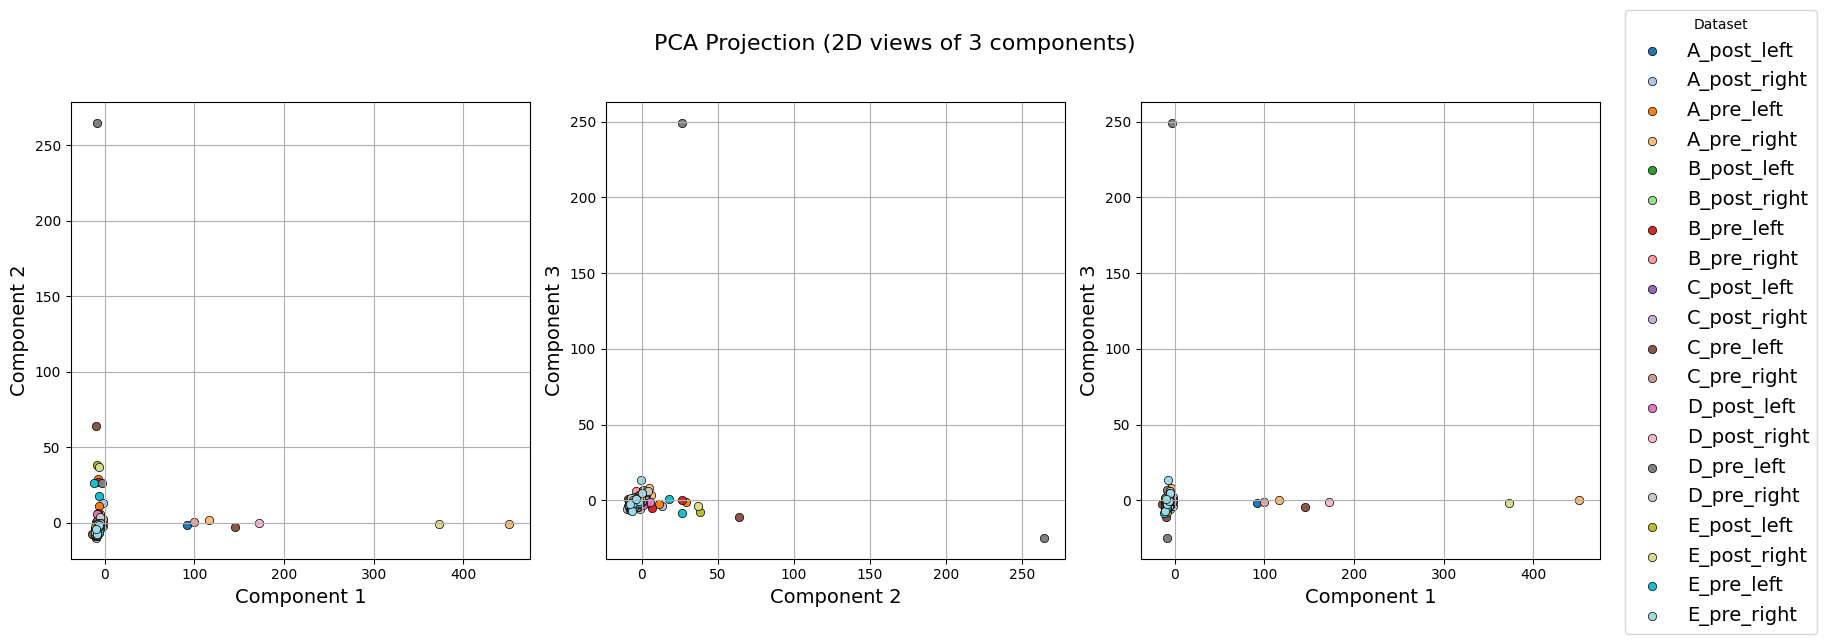

--------------------------------------------------
Top features for PCA1 (Explained Variance: 54.75%):
  • Mean step jerk X during swing - head std, Mean step jerk X during swing - base std, Mean step jerk X during swing - shoulder std, Mean step jerk X during swing - spine 2 std, Mean step acceleration X during swing - head std, Mean step jerk X during swing - hip std, Mean step jerk X during swing - elbow std, Mean step jerk X during swing - spine 1 std, Mean step acceleration X during swing - shoulder std, Mean step acceleration X during swing - base std
Top features for PCA2 (Explained Variance: 10.56%):
  • Mean step acceleration X during stance - head std, Mean step jerk X during stance - head std, Mean step acceleration X during stance - shoulder std, Mean step jerk X during stance - shoulder std, Mean step acceleration X during stance - spine 2 std, Mean step acceleration X during stance - spine 1 std, Mean phase acceleration during stance - spine - head std, Mean step jerk X d

(PCA(n_components=200),
           PCA1       PCA2      PCA3  Dataset  Mouse
 0    -9.973832  -9.019873 -3.730581        0      0
 1    -7.151592  -2.686273 -0.851029        2      0
 2    -9.765890  -9.933306 -5.945461        1      1
 3    -6.161013  -1.083122 -2.655525        3      1
 4    -6.909505  -1.564199 -0.666113        4      2
 ..         ...        ...       ...      ...    ...
 195 -10.028832  -6.611239 -3.455118        3     97
 196  92.065745  -1.052883 -1.880301        0     98
 197  -6.598247  -2.343321 -1.463025        2     98
 198  -2.350633  13.399266 -3.363368        1     99
 199  -8.454550  -5.860872 -2.413352        3     99
 
 [200 rows x 5 columns])

In [4]:
perform_dimensionality_reduction(X_agg, y_mouse, y_dataset,
                                dataset_label_map, mouse_label_map,
                                method="PCA", n_components=3,
                                plot=True, save=False)

## UMAP

/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/.venv/lib64/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/filthyweeb/Documents/SeriousStuff/Work/MScThesis/src/pain_analysis.py:237: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # leave space for external legend


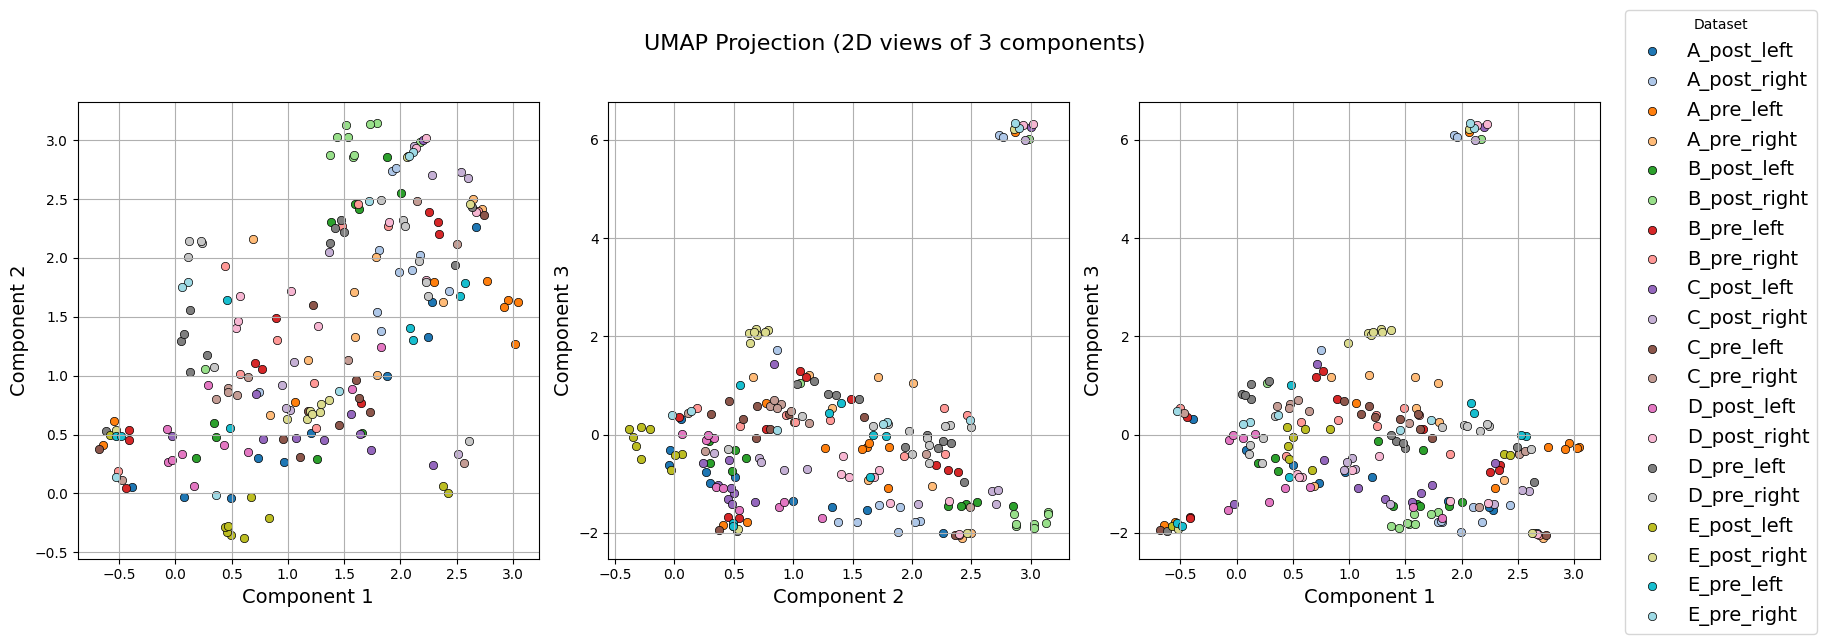

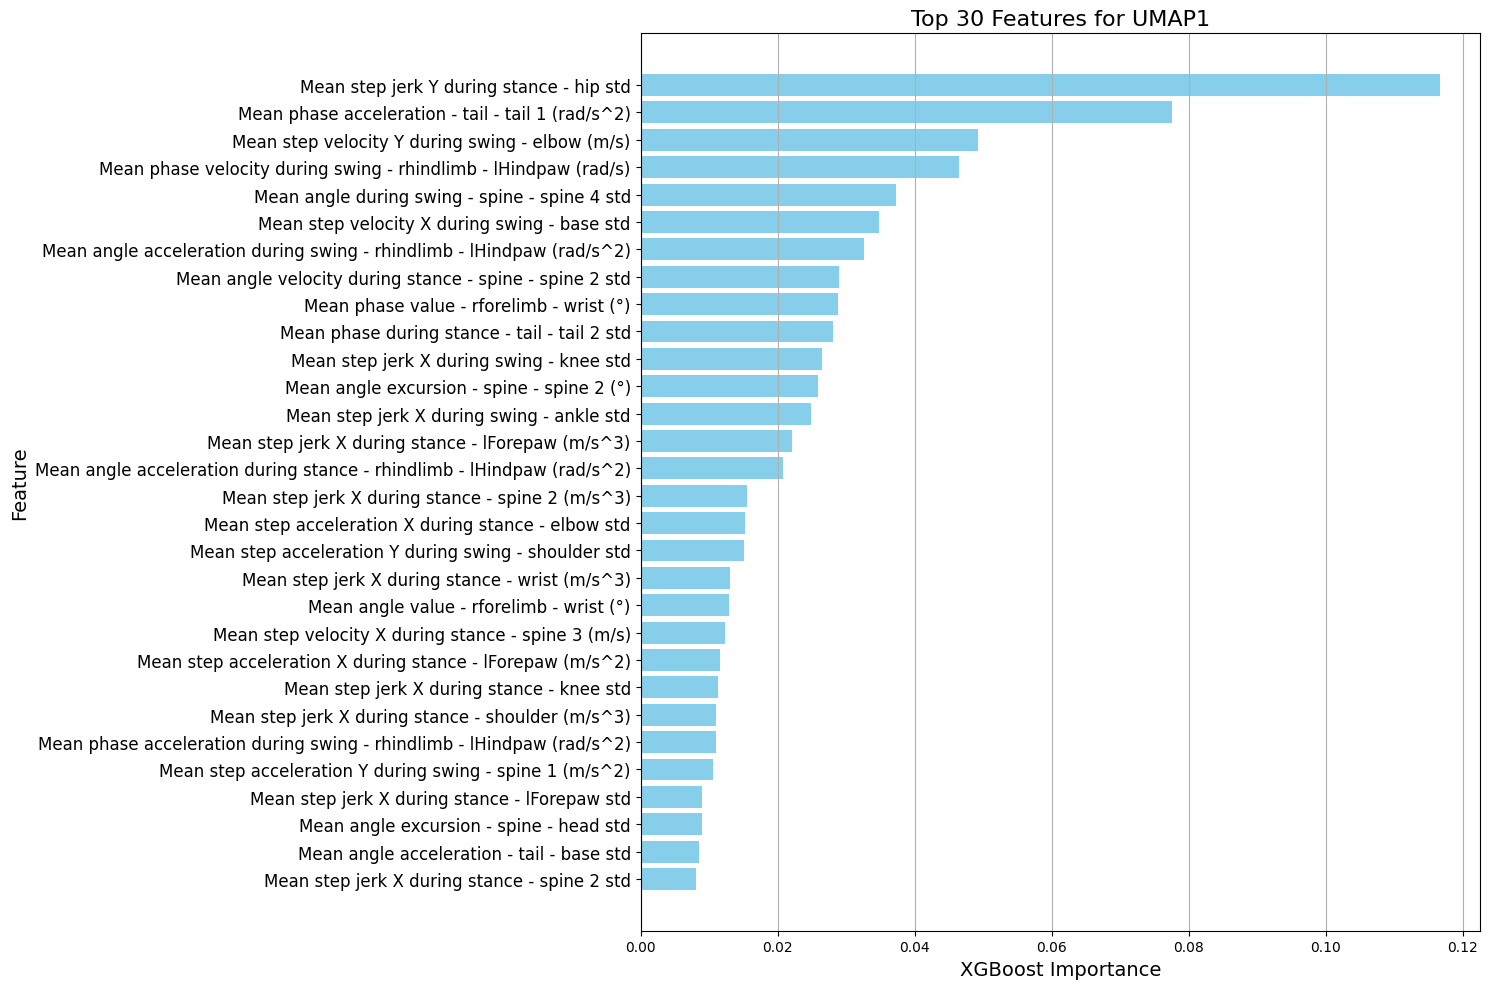

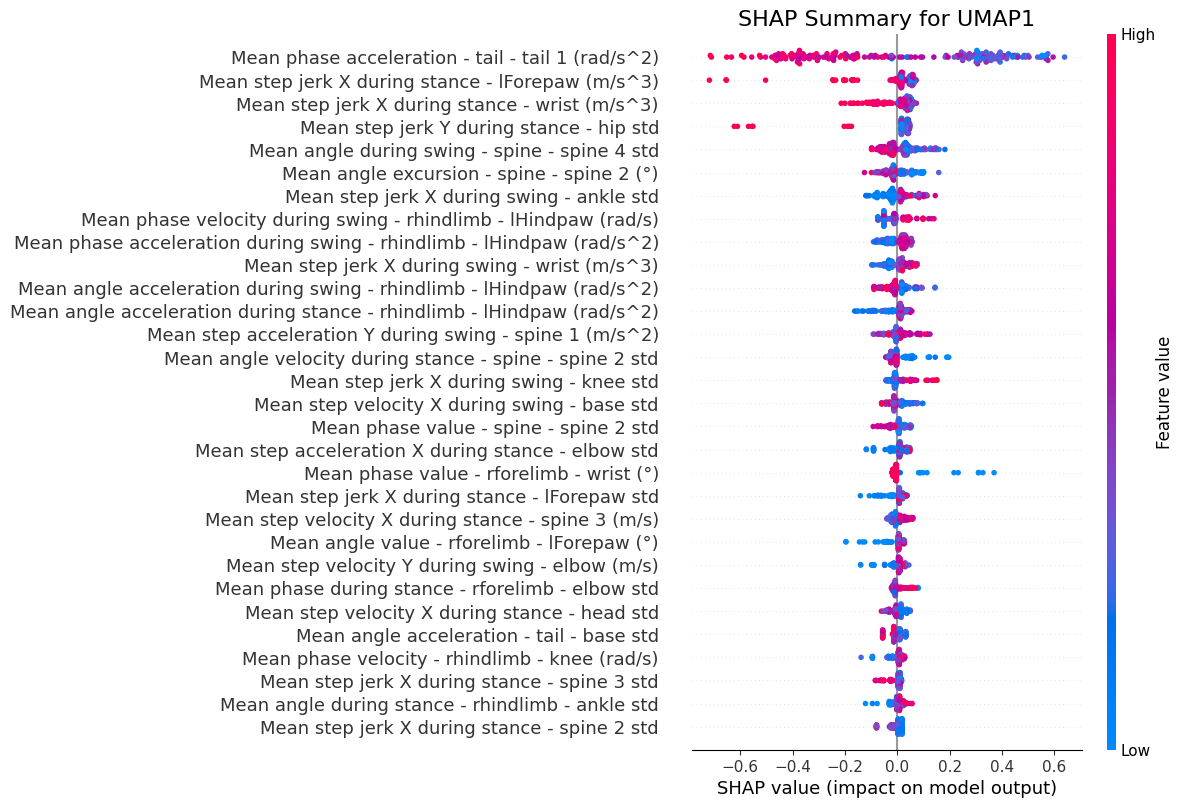

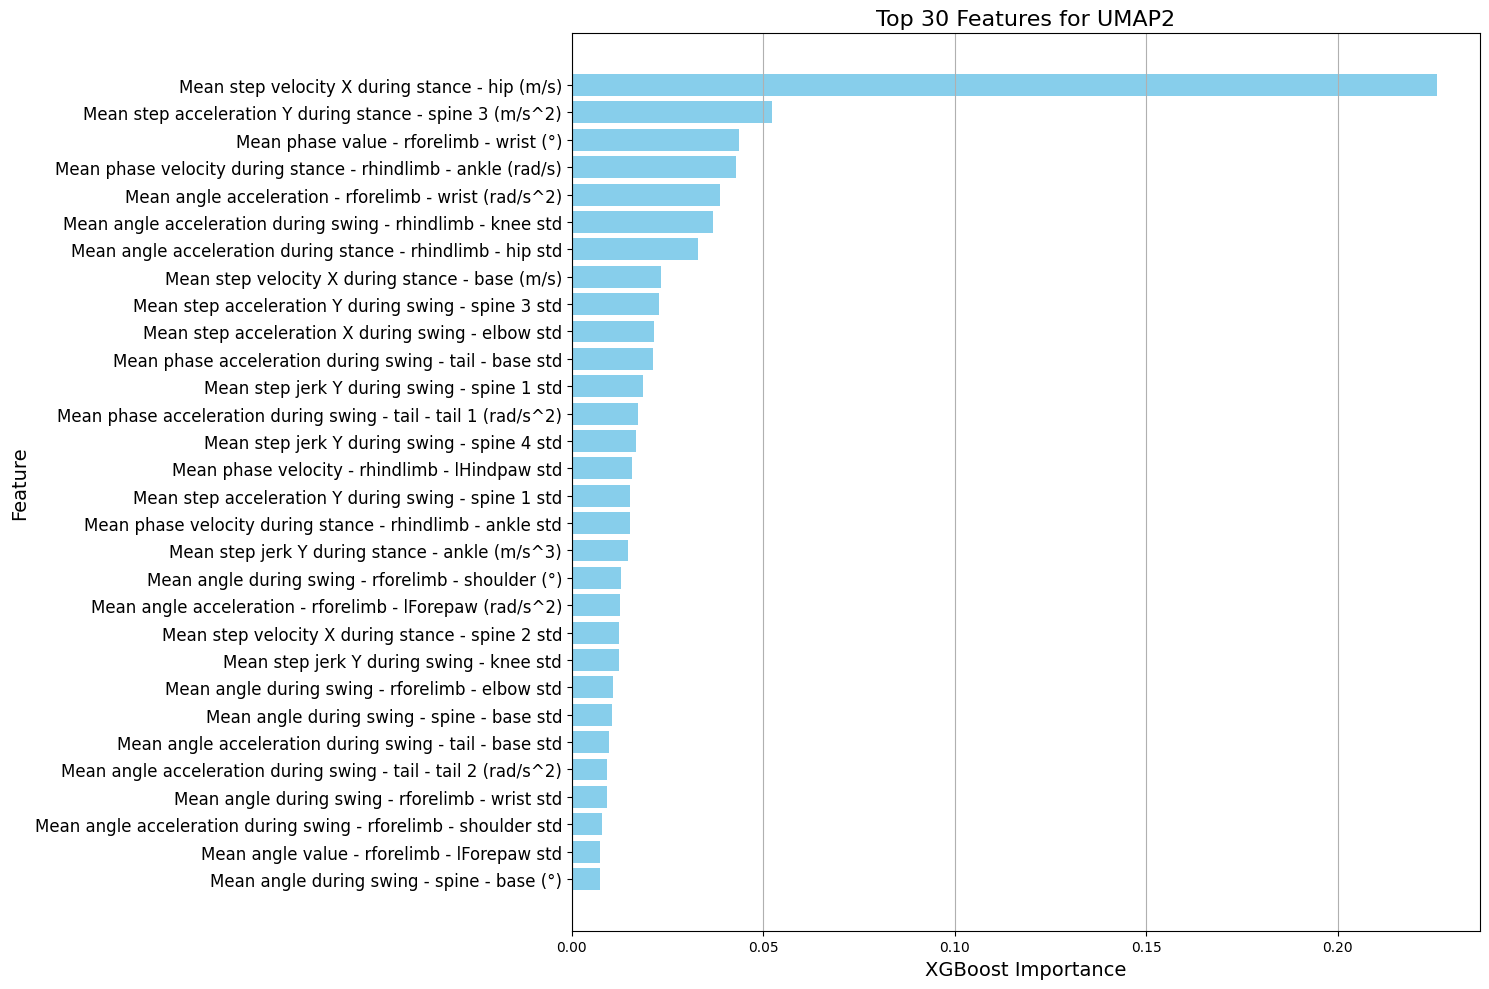

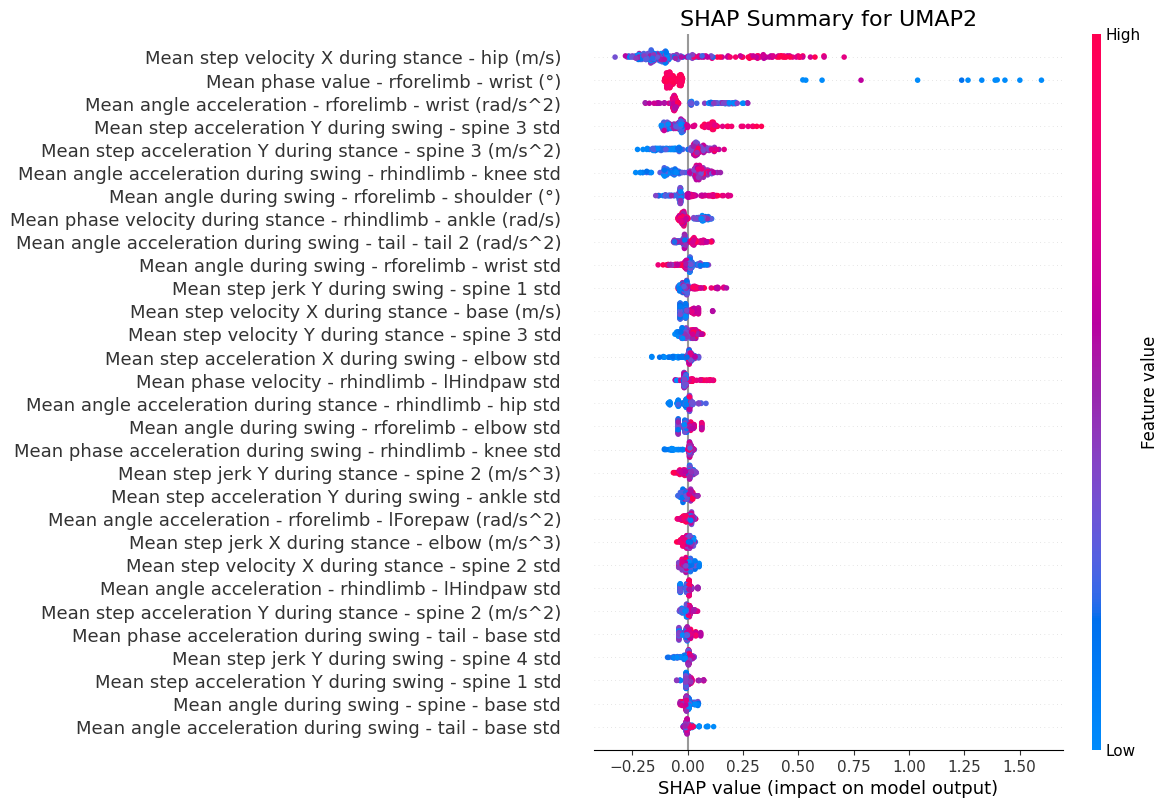

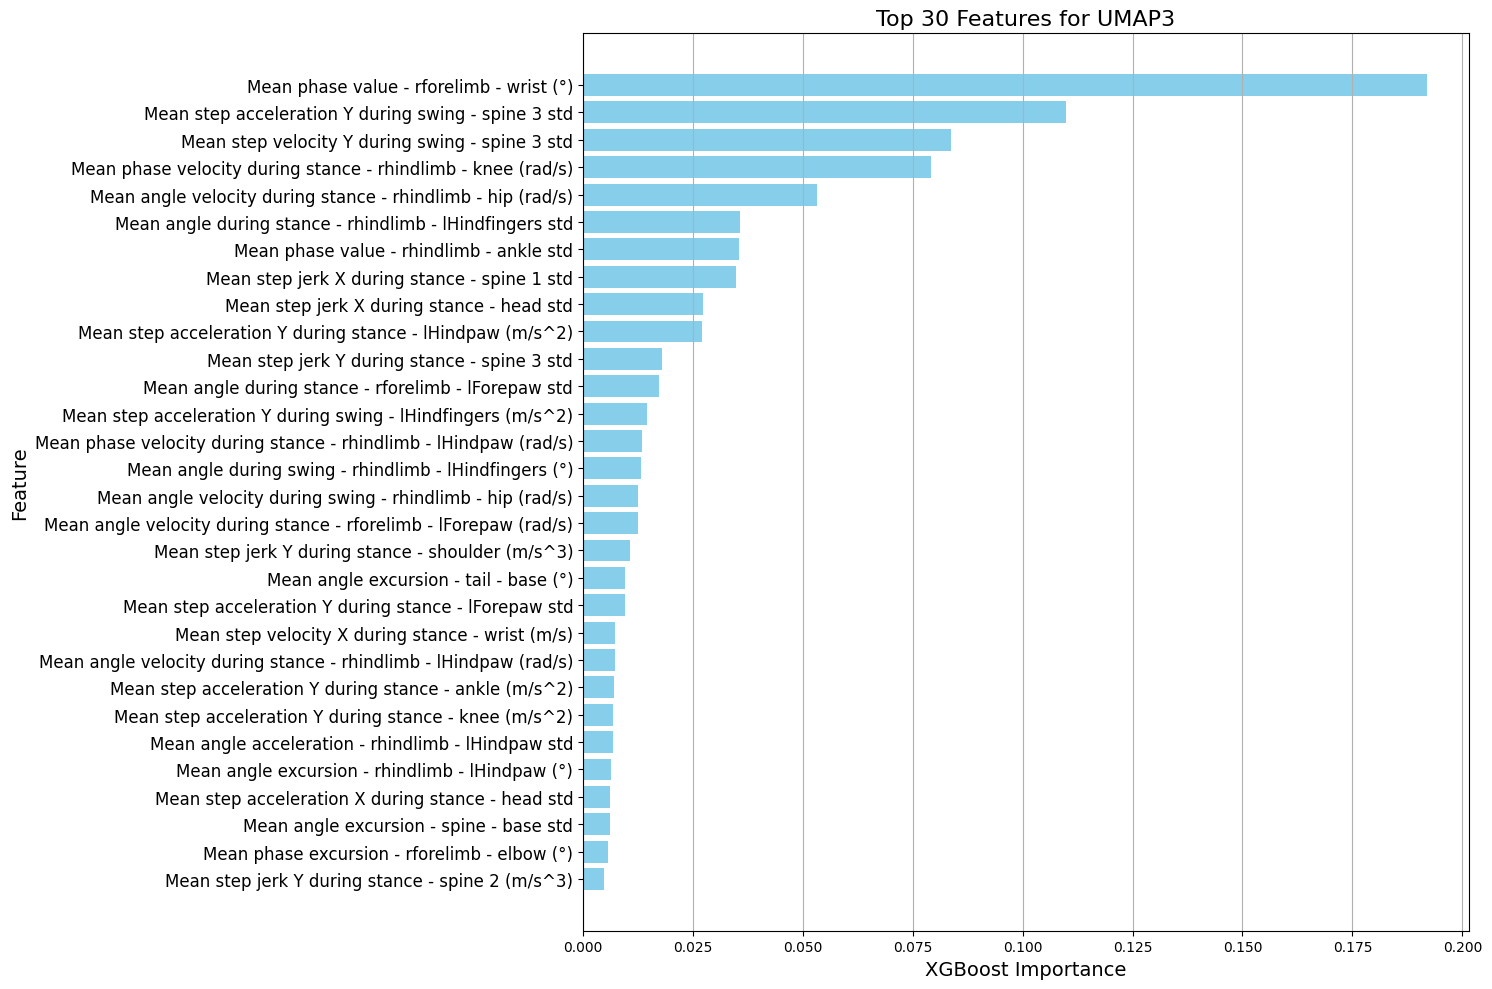

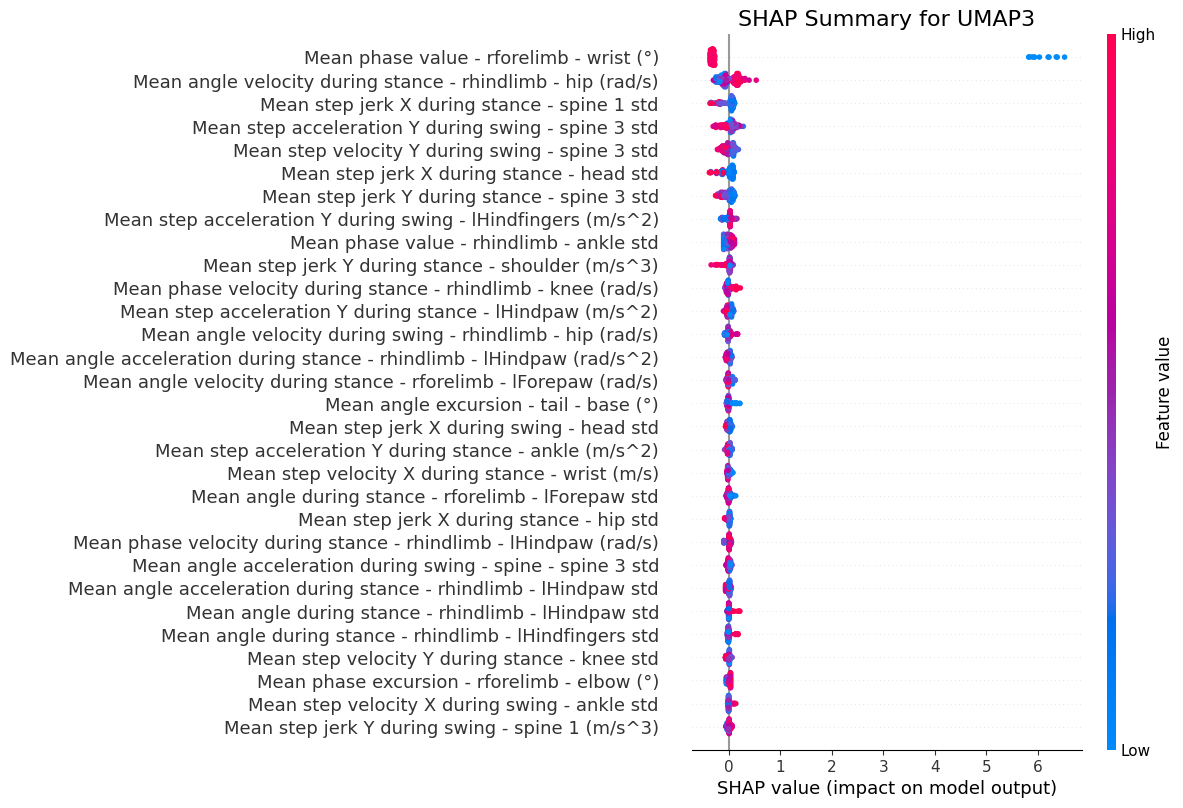

In [5]:
reducer, umap_plot_df = perform_dimensionality_reduction(
        X_agg, y_mouse, y_dataset,
        dataset_label_map, mouse_label_map,
        method="UMAP", n_components=3,
        target_metric='categorical',
        target_weight=0,
        n_neighbors=15,
        min_dist=0.05,
        plot=True, save=False
    )

# UMAP -> XGBoost feature importance
umap_embedding = umap_plot_df[["UMAP1", "UMAP2", "UMAP3"]].values
plot_umap_feature_importance_with_xgboost(X_agg, umap_embedding, top_k=30,
                                          save = False)

## UMAP projection of the left limb

In [8]:
SCATTER_SIZE = 6
SCATTER_LINE_WIDTH = 1
SCATTER_SYMBOL = 'circle'
LEGEND_FONT_SIZE = 18
TITLE_FONT_SIZE = 24
AXIS_FONT_SIZE = 16
AXIS_TITLE_FONT_SIZE = 20

PRE_LABEL = "pre"
POST_LABEL = "post"

# Extract the specific post conditions for left hindlimb
def extract_post_condition(label):
    if POST_LABEL in label.lower():
        return label
    else:
        return PRE_LABEL

umap_plot_df["Dataset_label"] = umap_plot_df["Dataset"].map(dataset_label_map)
umap_plot_df_left = umap_plot_df[umap_plot_df["Dataset_label"].str.contains("left")]

umap_plot_df_left["Condition"] = umap_plot_df_left["Dataset_label"].apply(lambda x: "Pre" if "pre" in x.lower() else "Post")

fig = px.scatter_3d(
    umap_plot_df_left,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="Condition",
    symbol=None,
    hover_data=umap_plot_df_left.columns,
    title="3D UMAP Projection of Filtered Datasets (pre vs post) in left hindlimb"
)
fig.update_traces(marker=dict(size=SCATTER_SIZE, line=dict(width=SCATTER_LINE_WIDTH, color='DarkSlateGrey'), symbol=SCATTER_SYMBOL))
fig.update_layout(
    legend=dict(title="Condition", x=1.05, y=1, font=dict(size=LEGEND_FONT_SIZE)),
    width=900,
    height=700,
    scene=dict(
        xaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        yaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        zaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
    ),
    title=dict(font=dict(size=TITLE_FONT_SIZE))
)
fig.show()

umap_plot_df_left["Post_Condition"] = umap_plot_df_left["Dataset_label"].apply(extract_post_condition)

fig = px.scatter_3d(
    umap_plot_df_left,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="Post_Condition",
    symbol=None,
    hover_data=umap_plot_df_left.columns,
    title="3D UMAP Projection of Filtered Datasets in left hindlimb"
)
fig.update_traces(marker=dict(size=SCATTER_SIZE, line=dict(width=SCATTER_LINE_WIDTH, color='DarkSlateGrey'), symbol=SCATTER_SYMBOL))
fig.update_layout(
    legend=dict(title="Condition", x=1.05, y=1, font=dict(size=LEGEND_FONT_SIZE)),
    width=900,
    height=700,
    scene=dict(
        xaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        yaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        zaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
    ),
    title=dict(font=dict(size=TITLE_FONT_SIZE))
)
fig.show()

/tmp/ipykernel_78923/325586528.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_78923/325586528.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## UMAP Projection of the right limb

In [ ]:
umap_plot_df["Dataset_label"] = umap_plot_df["Dataset"].map(dataset_label_map)
umap_plot_df_right = umap_plot_df[umap_plot_df["Dataset_label"].str.contains("right")]

umap_plot_df_right["Condition"] = umap_plot_df_right["Dataset_label"].apply(lambda x: "Pre" if "pre" in x.lower() else "Post")

fig = px.scatter_3d(
    umap_plot_df_right,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="Condition",
    symbol=None,
    hover_data=umap_plot_df_right.columns,
    title="3D UMAP Projection of Filtered Datasets (pre vs post) in right hindlimb"
)
fig.update_traces(marker=dict(size=SCATTER_SIZE, line=dict(width=SCATTER_LINE_WIDTH, color='DarkSlateGrey'), symbol=SCATTER_SYMBOL))
fig.update_layout(
    legend=dict(title="Condition", x=1.05, y=1, font=dict(size=LEGEND_FONT_SIZE)),
    width=900,
    height=700,
    scene=dict(
        xaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        yaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        zaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
    ),
    title=dict(font=dict(size=TITLE_FONT_SIZE))
)
fig.show()

umap_plot_df_right["Post_Condition"] = umap_plot_df_right["Dataset_label"].apply(extract_post_condition)

fig = px.scatter_3d(
    umap_plot_df_right,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="Post_Condition",
    symbol=None,
    hover_data=umap_plot_df_right.columns,
    title="3D UMAP Projection of Filtered Datasets in right hindlimb"
)
fig.update_traces(marker=dict(size=SCATTER_SIZE, line=dict(width=SCATTER_LINE_WIDTH, color='DarkSlateGrey'), symbol=SCATTER_SYMBOL))
fig.update_layout(
    legend=dict(title="Condition", x=1.05, y=1, font=dict(size=LEGEND_FONT_SIZE)),
    width=900,
    height=700,
    scene=dict(
        xaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        yaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
        zaxis=dict(title_font=dict(size=AXIS_TITLE_FONT_SIZE), tickfont=dict(size=AXIS_FONT_SIZE)),
    ),
    title=dict(font=dict(size=TITLE_FONT_SIZE))
)
fig.show()

/tmp/ipykernel_78923/3600498871.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/tmp/ipykernel_78923/3600498871.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Trying to see the single features